In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rcParams
import time
from copy import copy

#from numba import int64

# #for 3d plots
# from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
# from mpl_toolkits.mplot3d import Axes3D
# #for 3d plots
# import matplotlib.animation as animation

#for saving simulations
# import pickle

from sim_handling import Simulation
from diffusionstuff7 import f0d,f1d,f2d

C:\Users\Max-PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\llvmlite\llvmpy\__init__.py:3: UserWarning: The module `llvmlite.llvmpy` is deprecated and will be removed in the future.
  warnings.warn(
C:\Users\Max-PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\llvmlite\llvmpy\core.py:8: UserWarning: The module `llvmlite.llvmpy.core` is deprecated and will be removed in the future. Equivalent functionality is provided by `llvmlite.ir`.
  warnings.warn(
C:\Users\Max-PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\llvmlite\llvmpy\passes.py:17: UserWarning: The module `llvmlite.llvmpy.passes` is deprecated and will be removed in the future. If you are using this code, it should be inlined into your own project.
  warnings.warn(


In [2]:
%matplotlib widget

In [3]:
f1d_sim = Simulation(f1d, (500,), rtol=1e-12)

In [4]:
#change parameters to match Gladich et al paper's graph and run simulation
f1d_sim.layermax = 500
#f1d_sim.center_reduction = 0.25 #is default now
f1d_sim.run()

breaking because reached max number of layers grown


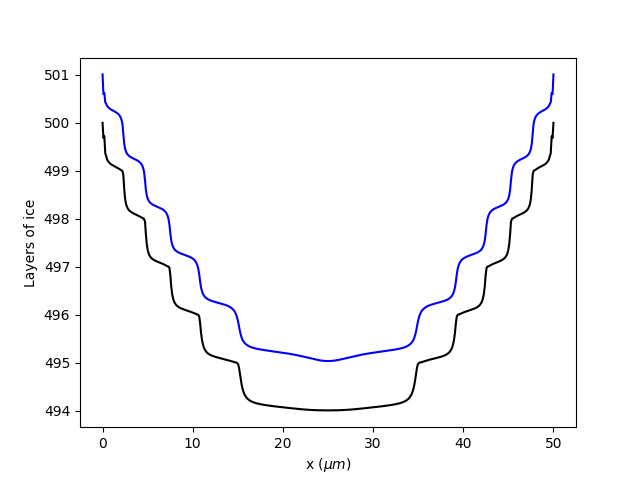

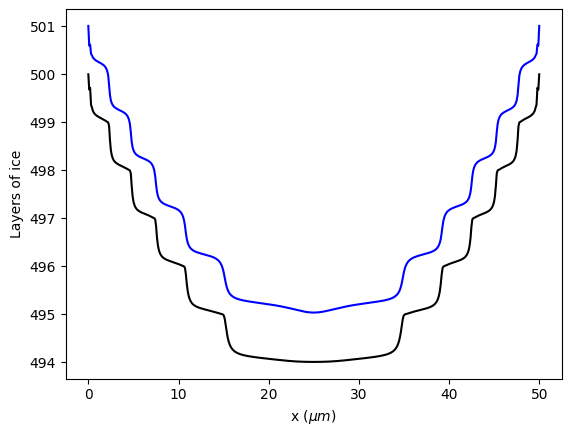

In [5]:
f1d_sim.plot(ice=True, tot=True)


In [6]:
for k,v in f1d_sim._extra_vars.items():
    print(k,v)
print('center reduction %: ', f1d_sim.center_reduction)

Nbar 1.0
Nstar 0.1432394487827058
D 0.0002
dtmax 50.20060160400962
dtmaxtimefactor 50
nu_kin 49
deprate 0.16333333333333333
sigma0 0.19
sigmastepmax 0.2
c_r 0.0025
niter 1
t0 0.0
DoverdeltaX2 0.01992008
nx 500
xmax 50
deltaX 0.10020040080160321
center reduction %:  0.25


In [7]:
test_f2d_sim = Simulation(f2d, (500,500), rtol=1e-12)
test_f2d_sim.layermax = 5

In [8]:
#test_f2d_sim.countermax_0D
#test_f2d_sim.countermax_1D
#test_f2d_sim.countermax_2D
#test_f2d_sim.atol
#test_f2d_sim.rtol
#test_f2d_sim.deltaT
#test_f2d_sim.float_params
#test_f2d_sim.animate()
#test_f2d_sim.run()

In [9]:
num_steps = len(test_f2d_sim.results()['t'])
#shape of results is (num_steps, 2, nx, ny)
Fliq, Ntot = [],[]
for step in range(num_steps):
    next_Fliq, next_Ntot = test_f2d_sim._results['y'][step]
    Fliq.append(next_Fliq)
    Ntot.append(next_Ntot)    
Fliq,Ntot = np.array(Fliq), np.array(Ntot)
Nice = Ntot - Fliq
#shape of fliq, ntot and nice should be (num_steps, nx, ny)

#access coordinate arrays for plotting
xs, ys = np.meshgrid(test_f2d_sim.x, test_f2d_sim.y)

breaking because reached max number of layers grown


In [10]:
print(num_steps)
print(test_f2d_sim.steepness(0,slice(0,test_f2d_sim.shape[0]//2)))

81
[array([-0.01027179, -0.00916466, -0.00983864, -0.01320386, -0.02023015,
       -0.03192621, -0.04907003, -0.07179159, -0.09912676, -0.12880988,
       -0.15758826, -0.18207377, -0.19973795, -0.20951497, -0.21177306,
       -0.20783528, -0.19939946, -0.18810195, -0.17529051, -0.16196143,
       -0.14878901, -0.13619116, -0.12439872, -0.1135145 , -0.10355844,
       -0.09449973, -0.08627871, -0.07882119, -0.07204743, -0.06587754,
       -0.06023462, -0.05504637, -0.05024586, -0.04577193, -0.04156943,
       -0.03758959, -0.03379095, -0.03014091, -0.02661852, -0.02321896,
       -0.01996048, -0.01689479, -0.01412218, -0.01181252, -0.01023329,
       -0.009784  , -0.01103299, -0.01474499, -0.02187584, -0.03349385,
       -0.0505774 , -0.07365681, -0.1023494 , -0.13497874, -0.16857575,
       -0.19945803, -0.22423034, -0.2407144 , -0.24834695, -0.24796109,
       -0.24121731, -0.23002086, -0.21612016, -0.20091613, -0.18542503,
       -0.17032327, -0.15602148, -0.14273859, -0.13056356, -

In [11]:
print(test_f2d_sim.get_step_density(0,slice(0,test_f2d_sim.shape[0]//2)))  

2.4733019676759227e-07
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
